In [69]:
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn
import math
from torchmetrics import Accuracy
from tqdm.auto import tqdm, trange
from pytorch_lightning.callbacks import RichProgressBar
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
torch.set_float32_matmul_precision('medium')

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class ImageNetDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, transform = None, preload: bool = True) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        self.preload = preload
        if ds_type == 'val':
            self.prepareValData()
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
        if self.preload:
            self._preload_images()
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def _preload_images(self) -> None:
        self.images = []
        self.labels = []
        
        if self.ds_type == 'val':
            for idx in trange(len(self.valData), desc="Preloading validation images"):
                data = self.valData[idx]
                img_path = os.path.join(self.root, self.ds_type, "images", data[0])
                img = Image.open(img_path).convert('RGB')
                self.images.append(img)
                self.labels.append(self.label_to_idx[data[1]])
        else:
            total_images = len(self.classes) * 500
            pbar = tqdm(total=total_images, desc="Preloading training images")
            for label_idx, label in enumerate(self.classes):
                label_root = os.path.join(self.root, self.ds_type, label)
                for img_idx in range(500):
                    img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
                    img = Image.open(img_path).convert('RGB')
                    self.images.append(img)
                    self.labels.append(self.label_to_idx[label])
                    pbar.update(1)
            pbar.close()
    
    def __getitem__(self, index: int):
        if self.preload:
            img = self.images[index]
            label = self.labels[index]
        else:
            if self.ds_type == 'val':
                data = self.valData[index]
                img_path = os.path.join(self.root, self.ds_type, "images", data[0])
                label = self.label_to_idx[data[1]]
            else:
                label_idx = index // 500
                img_idx = index % 500
                label = self.classes[label_idx]
                label_root = os.path.join(self.root, self.ds_type, label)
                img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
                with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                    rows = f.readlines()
                    f.close()
                row = rows[img_idx]
                data = self._parseLine(row)
            
            img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img, torch.tensor(label))
        
    def __len__(self) -> int:
        #500 examples for each class
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)


In [6]:
class ImageNetDataModule(pl.LightningDataModule):
    def __init__(
        self,
        root: str,
        classes: list[str],
        batch_size: int = 128,
        num_workers: int = 4,
        preload: bool = True,
    ):
        super().__init__()
        self.root = root
        self.classes = classes
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.preload = preload

        self.train_transform = T.Compose([
            T.RandomResizedCrop(64),
            T.RandomHorizontalFlip(),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

        self.val_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage=None):
        if stage in ("fit", None):
            self.train_ds = ImageNetDataset(
                root=self.root,
                classes=self.classes,
                ds_type="train",
                transform=self.train_transform,
                preload=self.preload,
            )
            self.val_ds = ImageNetDataset(
                root=self.root,
                classes=self.classes,
                ds_type="val",
                transform=self.val_transform,
                preload=self.preload,
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )


In [7]:
class Patch2Embedding(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_size = cfg['img_size']
        self.patch_size = cfg['patch_size']
        self.channel_num = cfg['channel_num']
        self.embed_dim = cfg['embedding_dim']
        self.patch_num = (self.img_size // self.patch_size) ** 2
        self.patch_conv = nn.Conv2d(self.channel_num, self.embed_dim, self.patch_size, self.patch_size)
        
    def forward(self, x):
        #x : (N, C, H, W)
        #out : (N, patch_num, embed_dim)
        out = self.patch_conv(x)
        out = out.flatten(2).transpose(1,2)
        return out


In [8]:
class Embedding(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.patch_emb = Patch2Embedding(cfg)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg['embedding_dim']))
        self.pos_emb = nn.Parameter(torch.randn(1, self.patch_emb.patch_num+1, cfg['embedding_dim']))
        self.dropout = nn.Dropout(cfg['embedding_dropout'])
        
    def forward(self, x):
        #x : N, patch_num, embedding_dim
        out = self.patch_emb(x)
        batch_size = out.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        out = torch.cat((cls_tokens, out), dim=1)
        out = out + self.pos_emb
        out = self.dropout(out)
        return out


In [9]:
class AttentionHead(nn.Module):
    def __init__(self, hid_dim, head_dim, dropout, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hid_dim = hid_dim
        self.head_dim = head_dim
        self.dropout = nn.Dropout(dropout)
        self.query = nn.Linear(hid_dim, head_dim)
        self.key = nn.Linear(hid_dim, head_dim)
        self.value = nn.Linear(hid_dim, head_dim)
        
    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attn_scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(k.size(-1))
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.bmm(attn_probs, v)
        attn_out = self.dropout(attn_out)
        return attn_out


In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.head_num = cfg['attention_head_number']
        self.hid_dim = cfg['hidden_dim']
        assert self.hid_dim % self.head_num == 0
        head_dim = self.hid_dim // self.head_num
        self.heads = nn.ModuleList([AttentionHead(self.hid_dim, head_dim, cfg['attention_dropout']) for _ in range(self.head_num)])
        self.linear = nn.Linear(self.hid_dim, self.hid_dim)
        self.dropout = nn.Dropout(cfg['multihead_attention_dropout'])
        
    def forward(self, x):
        outputs = []
        for head in self.heads:
            output = head(x)
            outputs.append(output)
        output = torch.cat(outputs, dim=-1)
        output = self.linear(output)
        output = self.dropout(output)
        return output


In [11]:
class FFN(nn.Module):
    #do not search "mlp in transformer" in google
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hid_dim = cfg['hidden_dim']
        self.ffn_dim = cfg['ffn_dim']
        self.linear1 = nn.Linear(self.hid_dim, self.ffn_dim)
        self.linear2 = nn.Linear(self.ffn_dim, self.hid_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(cfg['ffn_dropout'])
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)
        out = self.dropout(out)
        return out


In [12]:
class BaseBlock(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hid_dim = cfg['hidden_dim']
        self.norm1 = nn.LayerNorm(self.hid_dim)
        self.mha = MultiHeadAttention(cfg)
        self.norm2 = nn.LayerNorm(self.hid_dim)
        self.ffn = FFN(cfg)
        
    def forward(self, x):
        out = self.norm1(x)
        out = out + self.mha(out)
        out = self.norm2(out)
        out = out + self.ffn(out)
        return out


In [13]:
class Encoder(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.block_num = cfg['block_number']
        self.blocks = nn.Sequential(*[BaseBlock(cfg) for _ in range(self.block_num)])
        
    def forward(self, x):
        out = self.blocks(x)
        return out


In [14]:
class ClassifierHead(nn.Module):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hid_dim = cfg['hidden_dim']
        self.class_num = cfg['class_number']
        self.linear = nn.Linear(self.hid_dim, self.class_num)
    
    def forward(self, x):
        logits = self.linear(x[:, 0]) #cls token
        probs = torch.softmax(logits, dim=-1)
        return logits, probs


In [15]:
class ViT(pl.LightningModule):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding_proj = Embedding(cfg)
        self.encoder = Encoder(cfg)
        self.classifier = ClassifierHead(cfg)
        
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task='multiclass', num_classes=cfg['class_number'])
        self.val_acc = Accuracy(task='multiclass', num_classes=cfg['class_number'])
        self.optimizer_cfg = cfg['optimizer']
        
        
    def forward(self, x):
        emb = self.embedding_proj(x)
        emb = self.encoder(emb)
        logits, probs = self.classifier(emb)
        return logits, probs
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits, _ = self(imgs)
        loss = self.criterion(logits, labels)
        self.log('train_loss', loss)
        self.train_acc(logits, labels)
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits, _ = self(imgs)
        loss = self.criterion(logits, labels)
        self.log('val_loss', loss)
        self.val_acc(logits, labels)
        self.log('val_acc', self.val_acc, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
        self.train_acc.reset()
        
    def configure_optimizers(self):
        cfg = self.optimizer_cfg
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=cfg['lr'],
            betas = cfg['betas'],
            weight_decay=cfg['weight_decay']
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs, eta_min=cfg['eta_min']
        )
        return {
            'optimizer' : optimizer,
            'lr_scheduler' : {
                'scheduler' : scheduler, 
                'interval' : 'epoch'
            }
        }


In [16]:
def get_tiny_imagenet_classes(root: str):
    train_root = os.path.join(root, "train")
    classes = sorted([d for d in os.listdir(train_root)
                      if os.path.isdir(os.path.join(train_root, d))])
    return classes


In [17]:
root = "./data/tiny-imagenet-200"

classes = get_tiny_imagenet_classes(root)
# assert len(classes) == config["class_number"], \
#     f"Ожидается {config['class_number']} классов, найдено {len(classes)}"

print(f"Found {len(classes)} classes")

Found 200 classes


In [18]:
dm = ImageNetDataModule(
    root=root,
    classes=classes,
    batch_size=512,
    num_workers=0,
    preload=True
)

In [19]:
checkpoint_cb = pl.callbacks.ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="./checkpoints/vit-tinyimagenet-{epoch:02d}-{val_acc:.4f}",
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")


In [20]:
progress_bar = RichProgressBar()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator=device,
    devices=1,
    precision="16-mixed",
    callbacks=[checkpoint_cb, lr_monitor, progress_bar],
    log_every_n_steps=50,
    enable_progress_bar=True,
    enable_model_summary=True,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [72]:
def plot_metrics(path):
    metrics_df = pd.read_csv(path)
    val_metrics_df = metrics_df[["epoch", "val_acc", "val_loss"]].dropna().reset_index(drop=True)
    val_metrics_df['train_acc'] = metrics_df['train_acc_epoch'].dropna().reset_index(drop=True)
    val_metrics_df['train_loss'] = metrics_df[['epoch', 'train_loss']].groupby('epoch').mean().reset_index()['train_loss']
    val_metrics_df.head()


    sns.set_style("whitegrid")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.lineplot(data=val_metrics_df, x='epoch', y='train_loss', label='Train Loss', ax=ax1, marker='o')
    sns.lineplot(data=val_metrics_df, x='epoch', y='val_loss', label='Val Loss', ax=ax1, marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    sns.lineplot(data=val_metrics_df, x='epoch', y='train_acc', label='Train Accuracy', ax=ax2, marker='o')
    sns.lineplot(data=val_metrics_df, x='epoch', y='val_acc', label='Val Accuracy', ax=ax2, marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Подбор конфигурации

## Базовая модель

In [ ]:
config = {
    #model size
    'img_size' : 64,
    
    'patch_size' : 16,
    'channel_num' : 3,
    'embedding_dim' : 192,
    'hidden_dim' : 192,
    'ffn_dim' : 192 * 4,
    'attention_head_number' : 3,
    'block_number' : 7,
    'class_number' : 200,
    
    #dropout probs
    'embedding_dropout' : 0.1,
    'ffn_dropout' : 0.1,
    'multihead_attention_dropout' : 0.1,
    'attention_dropout' : 0.1,
    
    #optimizer
    'optimizer' : {
        'lr' : 1e-3,
        'betas' : (0.9, 0.95),
        'weight_decay' : 0.1,
        'eta_min' : 1e-6
    }
}

model = ViT(config)
trainer.fit(model, datamodule=dm)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dm.val_dataloader(), desc="Generating predictions"):
        imgs, labels = batch
        imgs = imgs.to(model.device)
        logits, _ = model(imgs)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

Preloading training images:   0%|          | 0/100000 [00:00<?, ?it/s]

Preloading validation images:   0%|          | 0/10000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ embedding_proj │ Embedding          │  151 K │ train │     0 │
│ 1 │ encoder        │ Encoder            │  3.1 M │ train │     0 │
│ 2 │ classifier     │ ClassifierHead     │ 38.6 K │ train │     0 │
│ 3 │ criterion      │ CrossEntropyLoss   │      0 │ train │     0 │
│ 4 │ train_acc      │ MulticlassAccuracy │      0 │ train │     0 │
│ 5 │ val_acc        │ MulticlassAccuracy │      0 │ train │     0 │
└───┴────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 200                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py
:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py
:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of
the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


Generating predictions:   0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   n01443537     0.6667    0.6800    0.6733        50
   n01629819     0.3038    0.4800    0.3721        50
   n01641577     0.2368    0.1800    0.2045        50
   n01644900     0.1944    0.1400    0.1628        50
   n01698640     0.2889    0.2600    0.2737        50
   n01742172     0.1429    0.1400    0.1414        50
   n01768244     0.2917    0.4200    0.3443        50
   n01770393     0.2703    0.2000    0.2299        50
   n01774384     0.3580    0.5800    0.4427        50
   n01774750     0.2791    0.2400    0.2581        50
   n01784675     0.3611    0.2600    0.3023        50
   n01855672     0.3803    0.5400    0.4463        50
   n01882714     0.3962    0.4200    0.4078        50
   n01910747     0.5789    0.6600    0.6168        50
   n01917289     0.5417    0.5200    0.5306        50
   n01944390     0.1750    0.1400    0.1556        50
   n01945685     0.3030    0.2000    0.2410        50
   n01950731     0.3421    

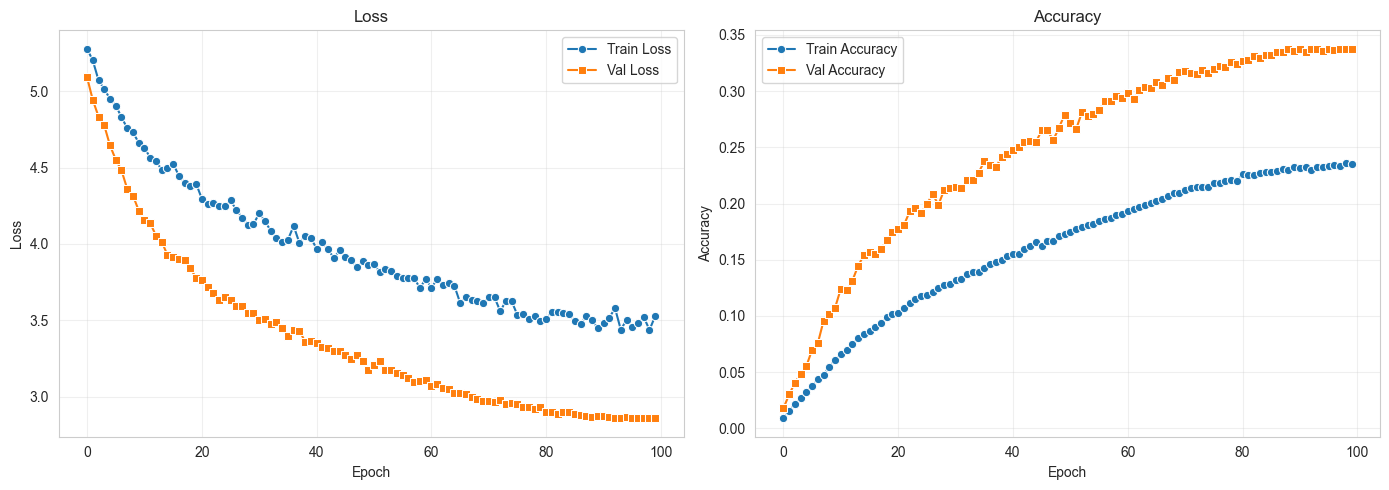

In [75]:
plot_metrics('lightning_logs/version_10/metrics.csv')

## Уменьшим размер патча

In [ ]:
config = {
    #model size
    'img_size' : 64,
    'patch_size' : 8,
    'channel_num' : 3,
    'embedding_dim' : 192,
    'hidden_dim' : 192,
    'ffn_dim' : 192 * 4,
    'attention_head_number' : 3,
    'block_number' : 7,
    'class_number' : 200,
    
    #dropout probs
    'embedding_dropout' : 0.1,
    'ffn_dropout' : 0.1,
    'multihead_attention_dropout' : 0.1,
    'attention_dropout' : 0.1,
    
    #optimizer
    'optimizer' : {
        'lr' : 1e-3,
        'betas' : (0.9, 0.95),
        'weight_decay' : 0.1,
        'eta_min' : 1e-6
    }
}


model = ViT(config)
trainer.fit(model, datamodule=dm)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dm.val_dataloader(), desc="Generating predictions"):
        imgs, labels = batch
        imgs = imgs.to(model.device)
        logits, _ = model(imgs)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

Preloading training images:   0%|          | 0/100000 [00:00<?, ?it/s]

Preloading validation images:   0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory c:\Users\mgsds\projects\ViT-ImageNet\lightning_logs\version_10\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ embedding_proj │ Embedding          │ 49.7 K │ train │     0 │
│ 1 │ encoder        │ Encoder            │  3.1 M │ train │     0 │
│ 2 │ classifier     │ ClassifierHead     │ 38.6 K │ train │     0 │
│ 3 │ criterion      │ CrossEntropyLoss   │      0 │ train │     0 │
│ 4 │ train_acc      │ MulticlassAccuracy │      0 │ train │     0 │
│ 5 │ val_acc        │ MulticlassAccuracy │      0 │ train │     0 │
└───┴────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 200                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py
:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

c:\Users\mgsds\projects\ViT-ImageNet\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py
:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of
the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=100` reached.


Generating predictions:   0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   n01443537     0.7568    0.5600    0.6437        50
   n01629819     0.6471    0.6600    0.6535        50
   n01641577     0.4688    0.3000    0.3659        50
   n01644900     0.4412    0.3000    0.3571        50
   n01698640     0.4762    0.4000    0.4348        50
   n01742172     0.1698    0.1800    0.1748        50
   n01768244     0.4026    0.6200    0.4882        50
   n01770393     0.3529    0.2400    0.2857        50
   n01774384     0.5909    0.7800    0.6724        50
   n01774750     0.5000    0.3000    0.3750        50
   n01784675     0.2766    0.2600    0.2680        50
   n01855672     0.4030    0.5400    0.4615        50
   n01882714     0.6857    0.4800    0.5647        50
   n01910747     0.6071    0.6800    0.6415        50
   n01917289     0.6471    0.6600    0.6535        50
   n01944390     0.4062    0.2600    0.3171        50
   n01945685     0.2647    0.1800    0.2143        50
   n01950731     0.6216    

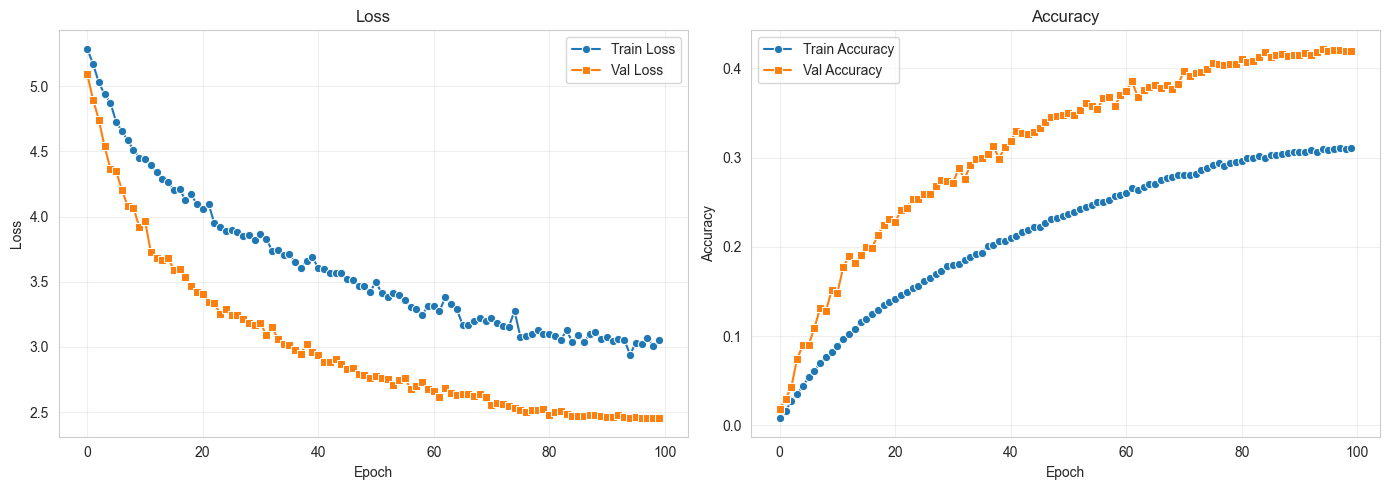

In [76]:
plot_metrics('lightning_logs/version_11/metrics.csv')

## Увеличим количество блоков

In [ ]:
config = {
    #model size
    'img_size' : 64,
    'patch_size' : 16,
    'channel_num' : 3,
    'embedding_dim' : 192,
    'hidden_dim' : 192,
    'ffn_dim' : 192 * 4,
    'attention_head_number' : 3,
    'block_number' : 9,
    'class_number' : 200,
    
    #dropout probs
    'embedding_dropout' : 0.1,
    'ffn_dropout' : 0.1,
    'multihead_attention_dropout' : 0.1,
    'attention_dropout' : 0.1,
    
    #optimizer
    'optimizer' : {
        'lr' : 1e-5,
        'betas' : (0.9, 0.95),
        'weight_decay' : 0.1,
        'eta_min' : 1e-6
    }
}

trainer = pl.Trainer(
    max_epochs=100,
    accelerator=device,
    devices=1,
    precision="16-mixed",
    callbacks=[checkpoint_cb, lr_monitor, progress_bar],
    log_every_n_steps=50,
    enable_progress_bar=True,
    enable_model_summary=True,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm"
)


model = ViT(config)
trainer.fit(model, datamodule=dm)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dm.val_dataloader(), desc="Generating predictions"):
        imgs, labels = batch
        imgs = imgs.to(model.device)
        logits, _ = model(imgs)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Preloading training images:   0%|          | 0/100000 [00:00<?, ?it/s]

Preloading validation images:   0%|          | 0/10000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ embedding_proj │ Embedding          │  151 K │ train │     0 │
│ 1 │ encoder        │ Encoder            │  4.0 M │ train │     0 │
│ 2 │ classifier     │ ClassifierHead     │ 38.6 K │ train │     0 │
│ 3 │ criterion      │ CrossEntropyLoss   │      0 │ train │     0 │
│ 4 │ train_acc      │ MulticlassAccuracy │      0 │ train │     0 │
│ 5 │ val_acc        │ MulticlassAccuracy │      0 │ train │     0 │
└───┴────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 254                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Тут я уже руками стопнул обучение ибо стало понятно, что ничего их этой конфигурации не вытянуть